In [1]:
#!pip install pandas
#%matplotlib inline
import math
import numpy as np
import pandas as pd
import pandasql as ps
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sn
from pandas.api.types import CategoricalDtype
import IPython.display as ipd
from tqdm.notebook import tqdm, trange
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import random
from collections import Counter
from collections import defaultdict
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

import ast

from collections import defaultdict
from scipy.stats.stats import pearsonr

plt.rcParams['axes.formatter.useoffset']=False
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 150

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [2]:
df = pd.read_csv('flat_df_no_nulli.csv', index_col=0)

In [3]:
from sklearn.preprocessing import LabelEncoder

label_encoders = dict()
column2encode = ['ALBUM_type_']

for col in column2encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [4]:
df['target']=[1 if genre == 'Rock' else 0 for genre in df['TRACK_genre_top']]

<AxesSubplot:>

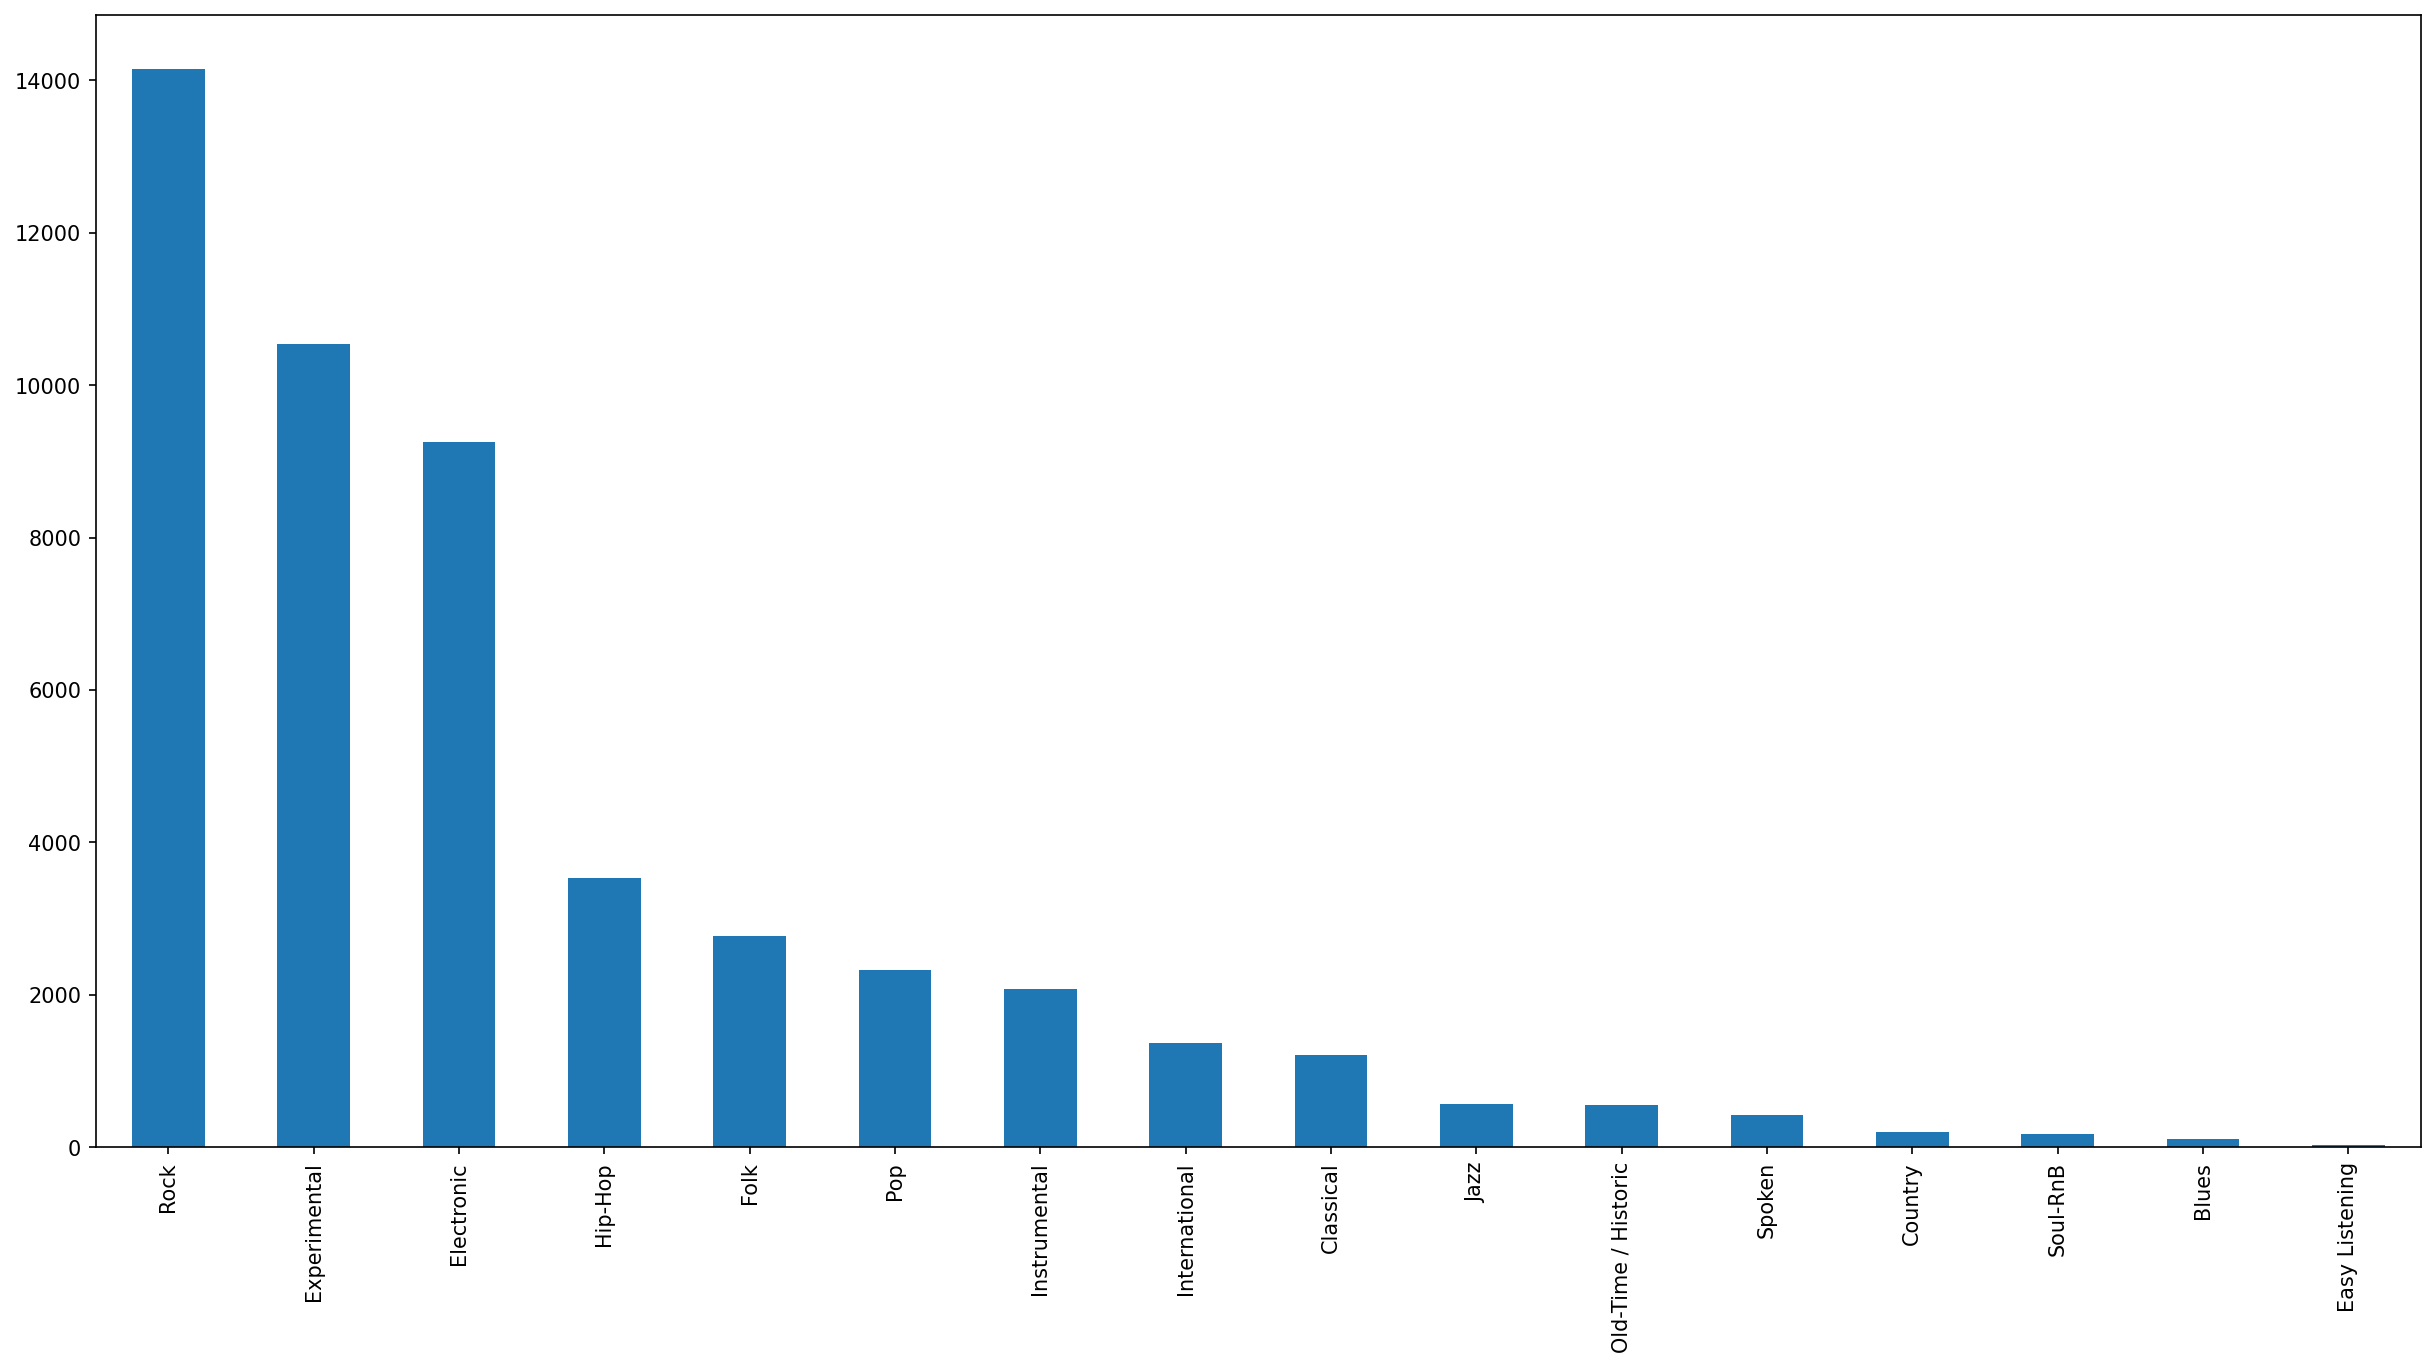

In [5]:
df.TRACK_genre_top.value_counts().plot(kind='bar')

In [6]:
df = df[df.TRACK_genre_top.isna() == False] #droppo i nulli

In [7]:
label_encoders = dict()
column2encode = ['TRACK_genre_top']

for col in column2encode:
    le = LabelEncoder()
    df['TRACK_genre_top_num'] = le.fit_transform(df[col])
    label_encoders[col] = le

In [62]:
df['TRACK_genre_top_num']=[0 if genre == 3 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 0 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 14 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 2 else genre for genre in df['TRACK_genre_top_num']]



df['TRACK_genre_top_num']=[0 if genre == 15 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 11 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 10 else genre for genre in df['TRACK_genre_top_num']]


df['TRACK_genre_top_num']=[3 if genre == 13 else genre for genre in df['TRACK_genre_top_num']] #rock 13 --> 3
df['TRACK_genre_top_num']=[2 if genre == 12 else genre for genre in df['TRACK_genre_top_num']] #pop 12 --> 2

<AxesSubplot:>

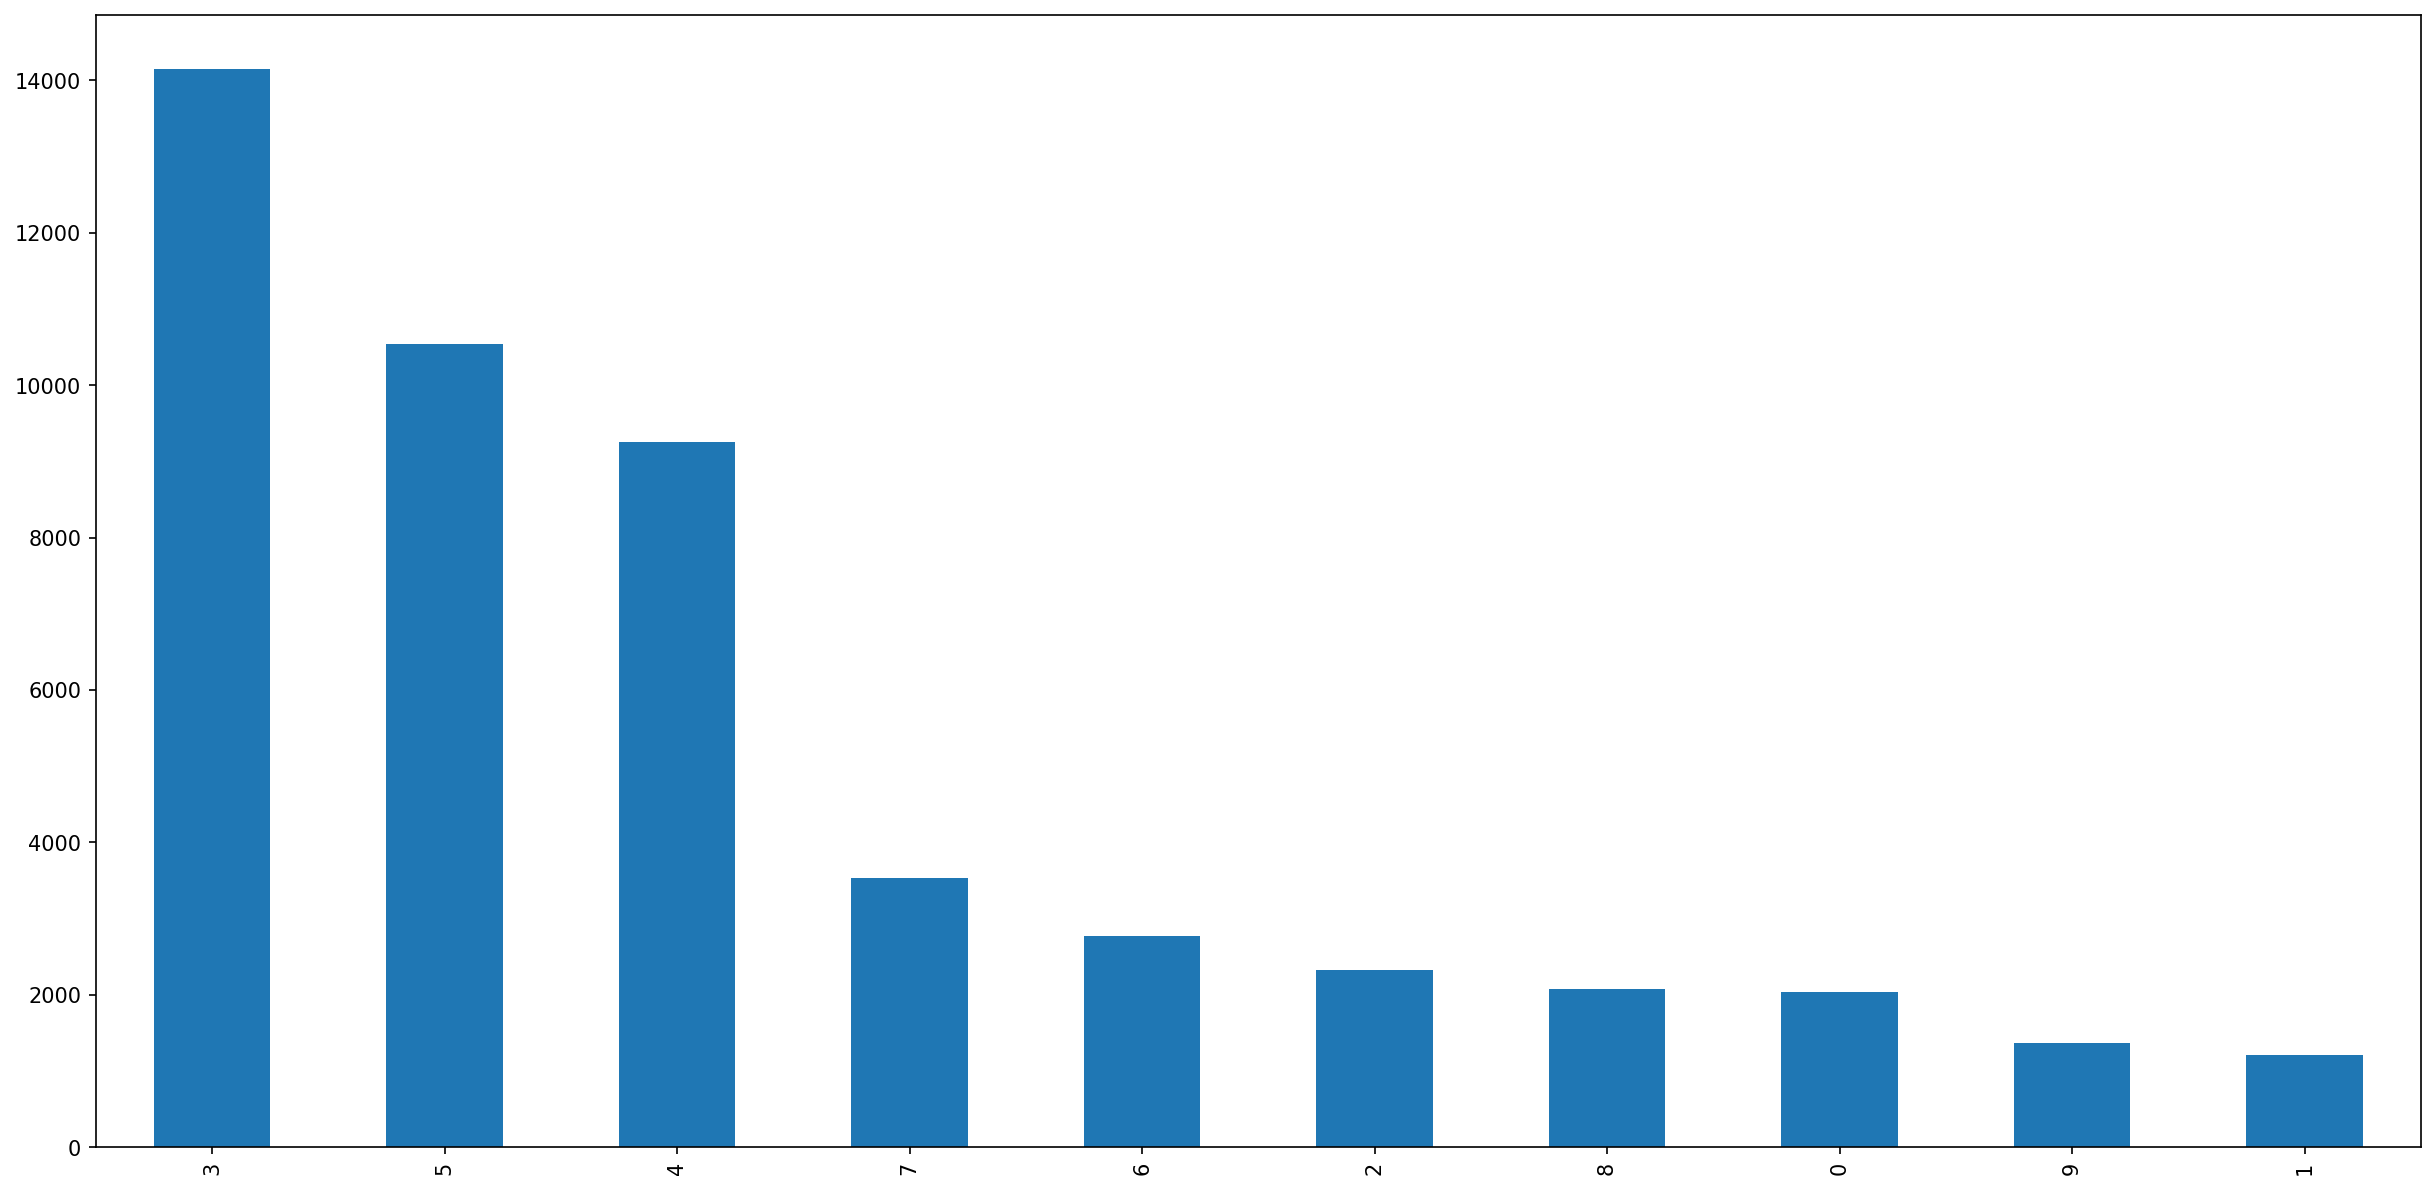

In [65]:
df.TRACK_genre_top_num.value_counts().plot(kind='bar')

In [10]:
features = [
 'chroma_censkurtosis',
 'chroma_censmax',
 'chroma_censmean',
 'chroma_censmedian',
 'chroma_censmin',
 'chroma_censskew',
 'chroma_censstd',
 'chroma_censcqtkurtosis',
 'chroma_cqtmax',
 'chroma_cqtmean',
 'chroma_cqtmedian',
 'chroma_cqtmin',
 'chroma_cqtskew',
 'chroma_cqtstd',
 'chroma_stftkurtosis',
 'chroma_stftmax',
 'chroma_stftmean',
 'chroma_stftmedian',
 'chroma_stftmin',
 'chroma_stftskew',
 'chroma_stftstd',
 'mfcckurtosis',
 'mfccmax',
 'mfccmean',
 'mfccmedian',
 'mfccmin',
 'mfccskew',
 'mfccstd',
 'spectral_contrastkurtosis',
 'spectral_contrastmax',
 'spectral_contrastmean',
 'spectral_contrastmedian',
 'spectral_contrastmin',
 'spectral_contrastskew',
 'spectral_contraststd',
 'tonnetzkurtosis',
 'tonnetzmax',
 'tonnetzmean',
 'tonnetzmedian',
 'tonnetzmin',
 'tonnetzskew',
 'tonnetzstd',
 'rmsekurtosis01',
 'rmsemax01',
 'rmsemean01',
 'rmsemedian01',
 'rmsemin01',
 'rmseskew01',
 'rmsestd01',
 'spectral_bandwidthkurtosis01',
 'spectral_bandwidthmax01',
 'spectral_bandwidthmean01',
 'spectral_bandwidthmedian01',
 'spectral_bandwidthmin01',
 'spectral_bandwidthskew01',
 'spectral_bandwidthstd01',
 'spectral_centroidkurtosis01',
 'spectral_centroidmax01',
 'spectral_centroidmean01',
 'spectral_centroidmedian01',
 'spectral_centroidmin01',
 'spectral_centroidskew01',
 'spectral_centroidstd01',
 'spectral_rolloffkurtosis01',
 'spectral_rolloffmax01',
 'spectral_rolloffmean01',
 'spectral_rolloffmedian01',
 'spectral_rolloffmin01',
 'spectral_rolloffskew01',
 'spectral_rolloffstd01',
 'zcrkurtosis01',
 'zcrmax01',
 'zcrmean01',
 'zcrmedian01',
 'zcrmin01',
 'zcrskew01',
 'zcrstd01',
]


bitmap = [
    'Blues',
 'Classical',
 'Country',
 'Easy Listening',
 'Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Jazz',
 'Old-Time / Historic',
 'Pop',
 'Rock',
 'Soul-RnB',
 'Spoken',
]

nulli = [
     'ALBUM_date_released_year',
    'ALBUM_favorites',
     'ALBUM_listens',
 'ALBUM_tracks',
 'ALBUM_type',
 'ARTIST_favorites',
 'ARTIST_location',
 'TRACK_favorites',
  'ARTIST_location_',
    'TRACK_genres_soloTop'
]

nonNumerici = [
    'ALBUM_tags',
    'ALBUM_title',
    'ARTIST_location_',
    'ARTIST_name',
    'ARTIST_tags',
    'SET_subset',
    'TRACK_genre_top',
    'TRACK_genres',
    'TRACK_genres_all',
    'TRACK_genres_soloTop',
    'TRACK_tags',
    'TRACK_title',
    'TRACK_genres_soloTop'
]

In [12]:
def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'])

compl.sort()

compl

['ALBUM_date_released_year_',
 'ALBUM_favorites_',
 'ALBUM_listens_',
 'ALBUM_tracks_',
 'ALBUM_type_',
 'ARTIST_favorites_',
 'TRACK_bitrate',
 'TRACK_duration',
 'TRACK_genre_top_num',
 'TRACK_interest',
 'TRACK_listens',
 'TRACK_number']

# Naive Bayes

In [44]:
class_name = 'TRACK_genre_top_num'

attributes = features
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

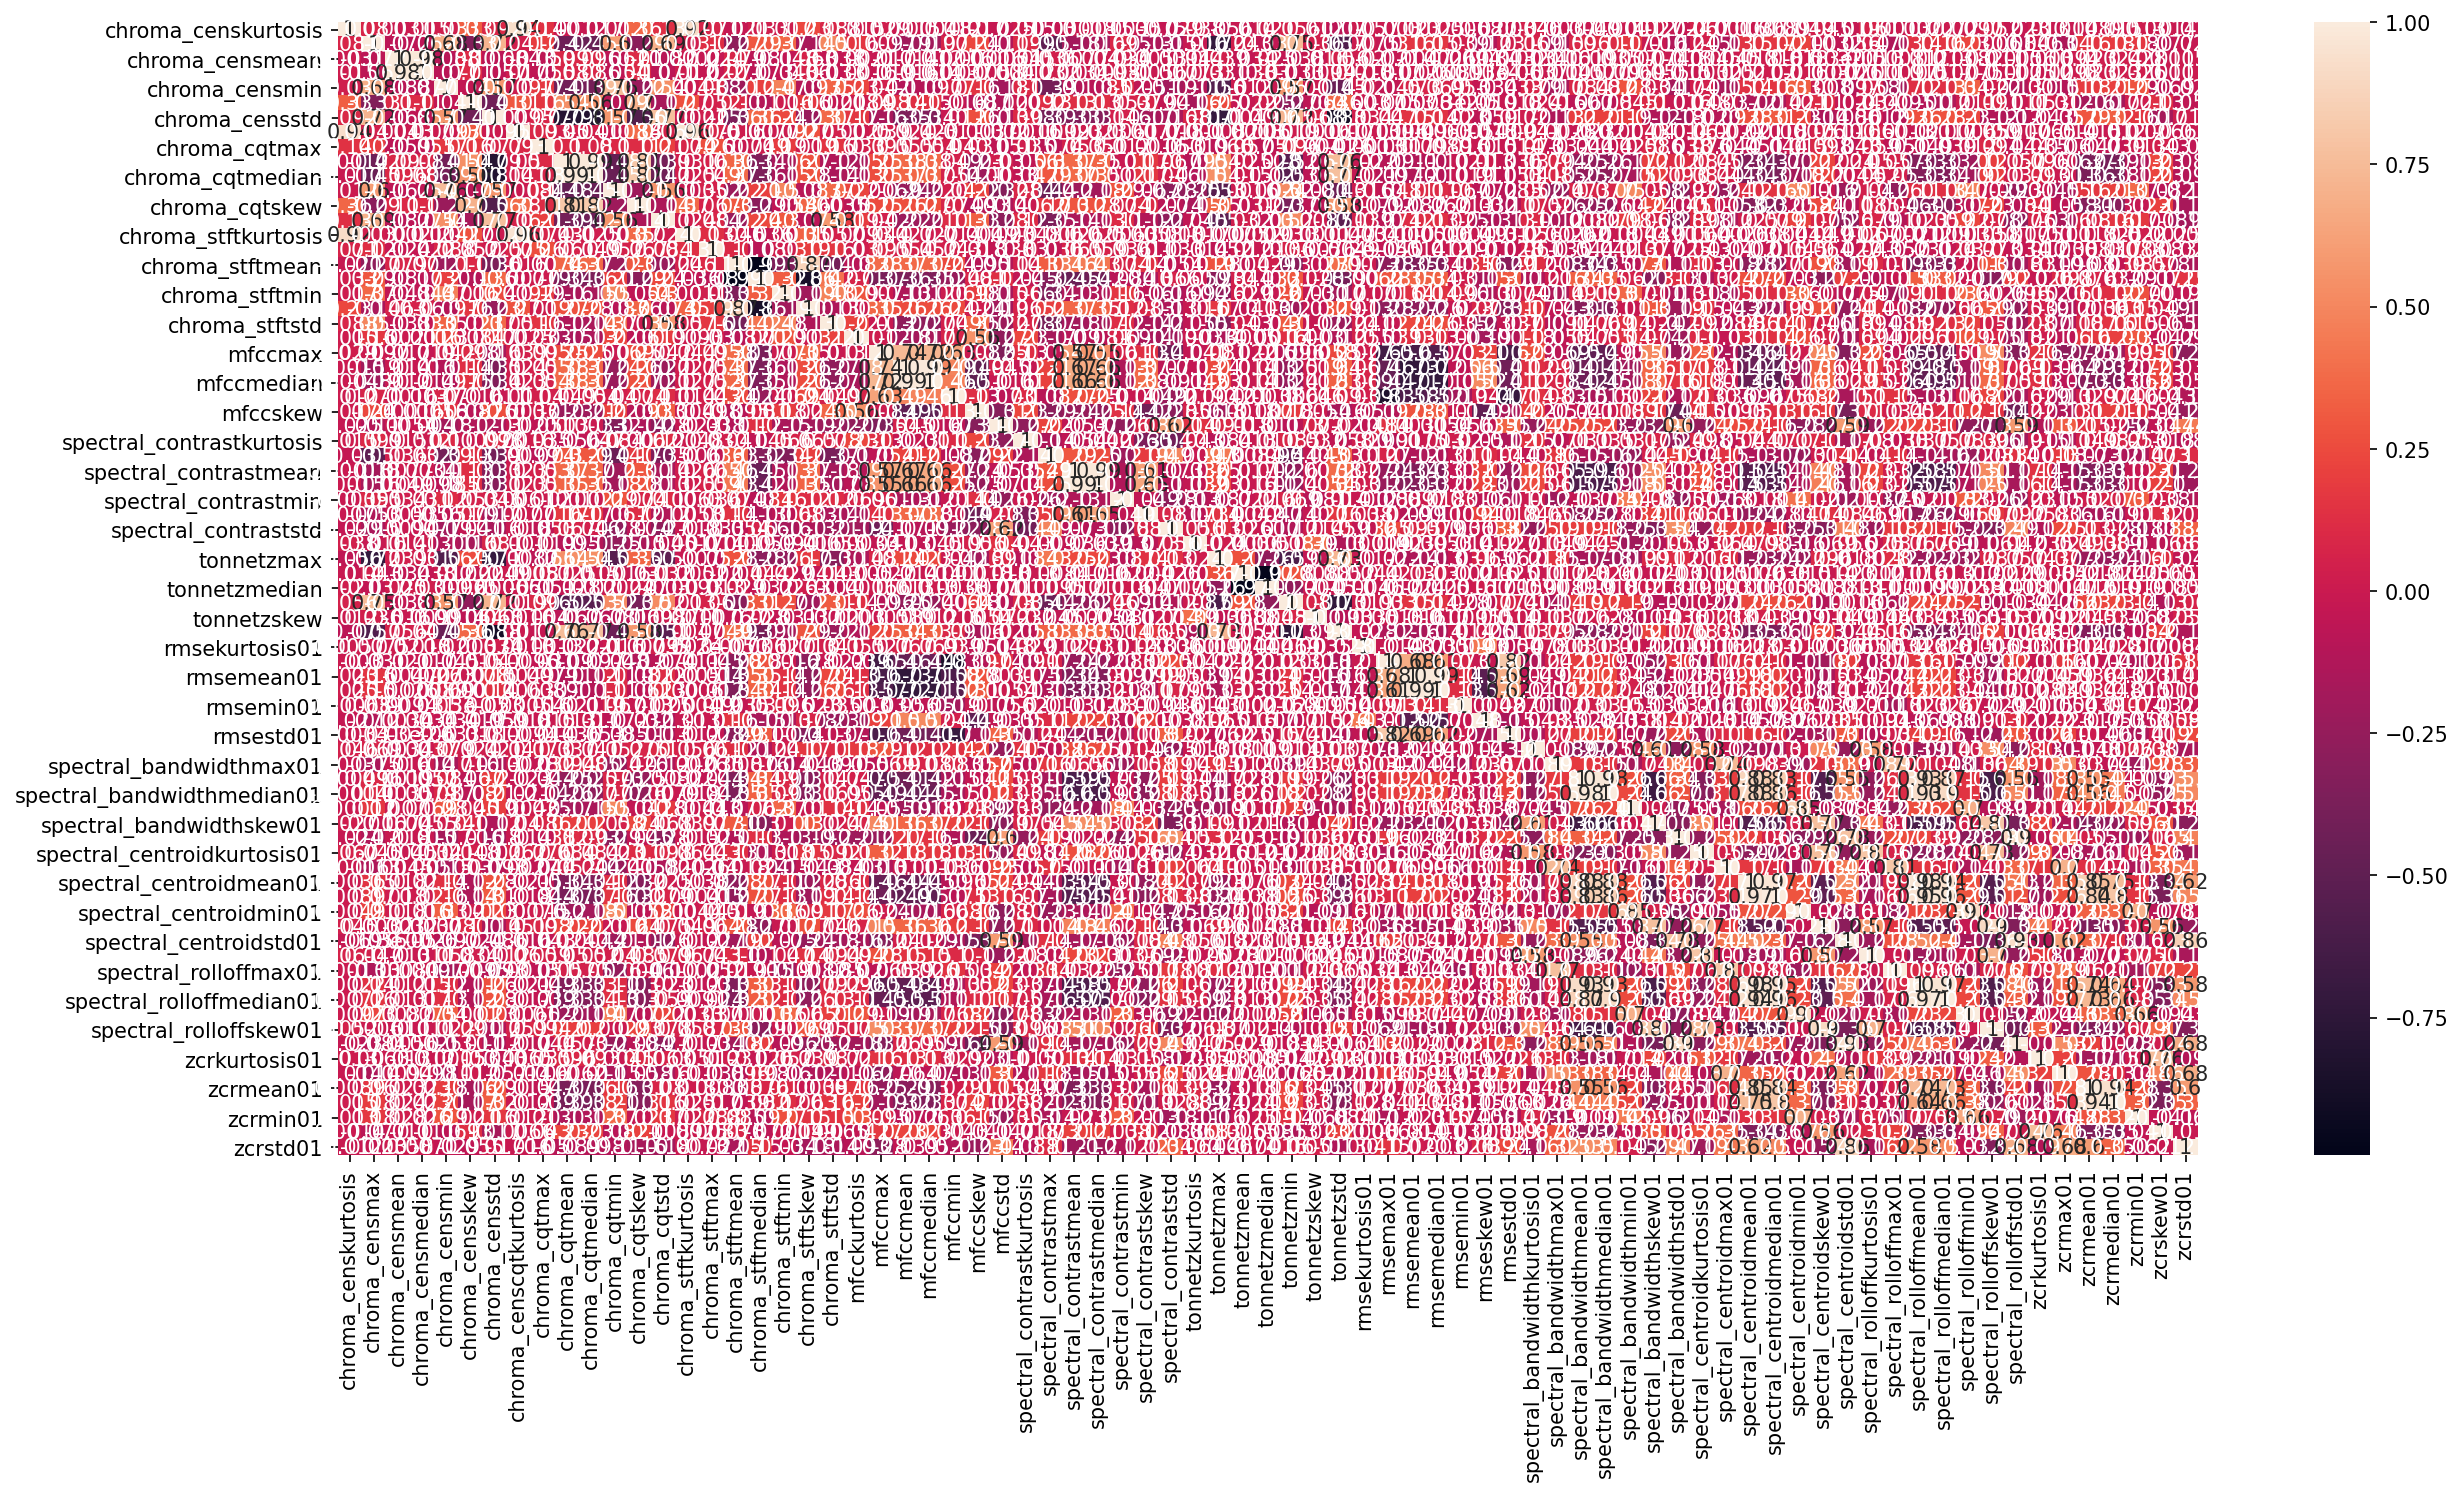

In [17]:
corrMatrix = df[attributes].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [45]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB

clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB()

In [46]:
y_pred = clf.predict(X_test)

In [47]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.2903334911722925
F1-score [0.39731544 0.13864307 0.12905044 0.28809074 0.2728513  0.14722911
 0.14912281 0.06736842 0.54788227 0.18162619]
              precision    recall  f1-score   support

           1       0.26      0.81      0.40       364
           4       0.38      0.08      0.14      2778
           5       0.59      0.07      0.13      3163
           6       0.21      0.46      0.29       832
           7       0.16      0.85      0.27      1061
           8       0.15      0.14      0.15       621
           9       0.10      0.33      0.15       409
          12       0.13      0.05      0.07       697
          13       0.70      0.45      0.55      4247
         100       0.26      0.14      0.18       611

    accuracy                           0.29     14783
   macro avg       0.29      0.34      0.23     14783
weighted avg       0.46      0.29      0.28     14783



# Logistic Regression

In [53]:
from sklearn.linear_model import LogisticRegression

In [52]:
class_name = 'TRACK_genre_top_num'

attributes = compl + features #Diff(compl + features, ('ALBUM_favorites_', 'ALBUM_listens_', 'TRACK_number', 'TRACK_interest'))
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [54]:
clf = LogisticRegression(random_state=0, max_iter=10000, class_weight='balanced') ## con il peso meglio f1, ma peggio accuracy
clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000, random_state=0)

In [55]:
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.4450382195765406
F1-score [0.43273013 0.45197496 0.32447684 0.33194329 0.42339479 0.26826196
 0.20262391 0.17146685 0.69906265 0.2898773 ]
              precision    recall  f1-score   support

           1       0.30      0.76      0.43       364
           4       0.56      0.38      0.45      2778
           5       0.63      0.22      0.32      3163
           6       0.25      0.48      0.33       832
           7       0.32      0.63      0.42      1061
           8       0.22      0.34      0.27       621
           9       0.14      0.34      0.20       409
          12       0.16      0.18      0.17       697
          13       0.73      0.67      0.70      4247
         100       0.27      0.31      0.29       611

    accuracy                           0.45     14783
   macro avg       0.36      0.43      0.36     14783
weighted avg       0.53      0.45      0.45     14783



# RIPPER


Non computabile con le features

# Orange (Rule based clf)

In [57]:
import Orange
from Orange.data.pandas_compat import table_from_frame

In [58]:
class_name = 'TRACK_genre_top_num'

attributes = compl#Diff(compl + features, ('ALBUM_favorites_', 'ALBUM_listens_', 'TRACK_number', 'TRACK_interest'))

out_data = table_from_frame(df[attributes])

In [91]:
cn2_learner = Orange.classification.rules.CN2Learner()
cn2_classifier = cn2_learner(out_data)

ValueError: Discrete class variable expected.

In [94]:
compl

['ALBUM_date_released_year_',
 'ALBUM_favorites_',
 'ALBUM_listens_',
 'ALBUM_tracks_',
 'ALBUM_type_',
 'ARTIST_favorites_',
 'TRACK_bitrate',
 'TRACK_duration',
 'TRACK_interest',
 'TRACK_listens',
 'TRACK_number']

# Linear SVM

In [26]:
from sklearn.svm import LinearSVC

class_name = 'TRACK_genre_top_num'

attributes = compl + features #Diff(compl + features, ('ALBUM_favorites_', 'ALBUM_listens_', 'TRACK_number', 'TRACK_interest'))
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [27]:
clf = LinearSVC(C=100, random_state=42, class_weight='balanced', max_iter= 10000, verbose = 10, dual=False)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

[LibLinear]Accuracy 0.5491442873570994
F1-score [0.92385787 0.4389929  0.47955316 0.4057844  0.44619423 0.3348281
 0.31369427 0.16462736 0.72368566 1.        ]
              precision    recall  f1-score   support

           1       0.86      1.00      0.92       364
           4       0.55      0.37      0.44      2778
           5       0.65      0.38      0.48      3163
           6       0.32      0.56      0.41       832
           7       0.34      0.64      0.45      1061
           8       0.31      0.36      0.33       621
           9       0.23      0.48      0.31       409
          12       0.37      0.11      0.16       697
          13       0.68      0.77      0.72      4247
         100       1.00      1.00      1.00       611

    accuracy                           0.55     14783
   macro avg       0.53      0.57      0.52     14783
weighted avg       0.58      0.55      0.54     14783



# Nonlinear SVM

In [16]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [22]:
class_name = 'TRACK_genre_top_num'

attributes = compl + features #Diff(compl + features, ('ALBUM_favorites_', 'ALBUM_listens_', 'TRACK_number', 'TRACK_interest'))
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [23]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [24]:
clf = SVC(gamma='auto', class_weight='balanced', verbose = True, cache_size=2048)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

[LibSVM]Accuracy 0.7578975850639248
F1-score [0.87258687 0.7523791  0.77141038 0.66562986 0.71812367 0.55730954
 0.66734486 0.48       0.85135841 0.99258038]
              precision    recall  f1-score   support

           1       0.82      0.93      0.87       364
           4       0.82      0.70      0.75      2778
           5       0.78      0.77      0.77      3163
           6       0.59      0.77      0.67       832
           7       0.66      0.79      0.72      1061
           8       0.49      0.65      0.56       621
           9       0.57      0.80      0.67       409
          12       0.40      0.61      0.48       697
          13       0.96      0.77      0.85      4247
         100       1.00      0.99      0.99       611

    accuracy                           0.76     14783
   macro avg       0.71      0.78      0.73     14783
weighted avg       0.79      0.76      0.77     14783



# Sklearn Multilayer Perceptron

In [22]:
class_name = 'target'

attributes = compl + features #Diff(compl + features, ('ALBUM_favorites_', 'ALBUM_listens_', 'TRACK_number', 'TRACK_interest'))
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [23]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
from sklearn.neural_network import MLPClassifier

In [25]:
clf = MLPClassifier(random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9044565869681943
F1-score [0.94556905 0.60952627]
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     27414
           1       0.67      0.56      0.61      4247

    accuracy                           0.90     31661
   macro avg       0.80      0.76      0.78     31661
weighted avg       0.90      0.90      0.90     31661



/home/cri98li/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


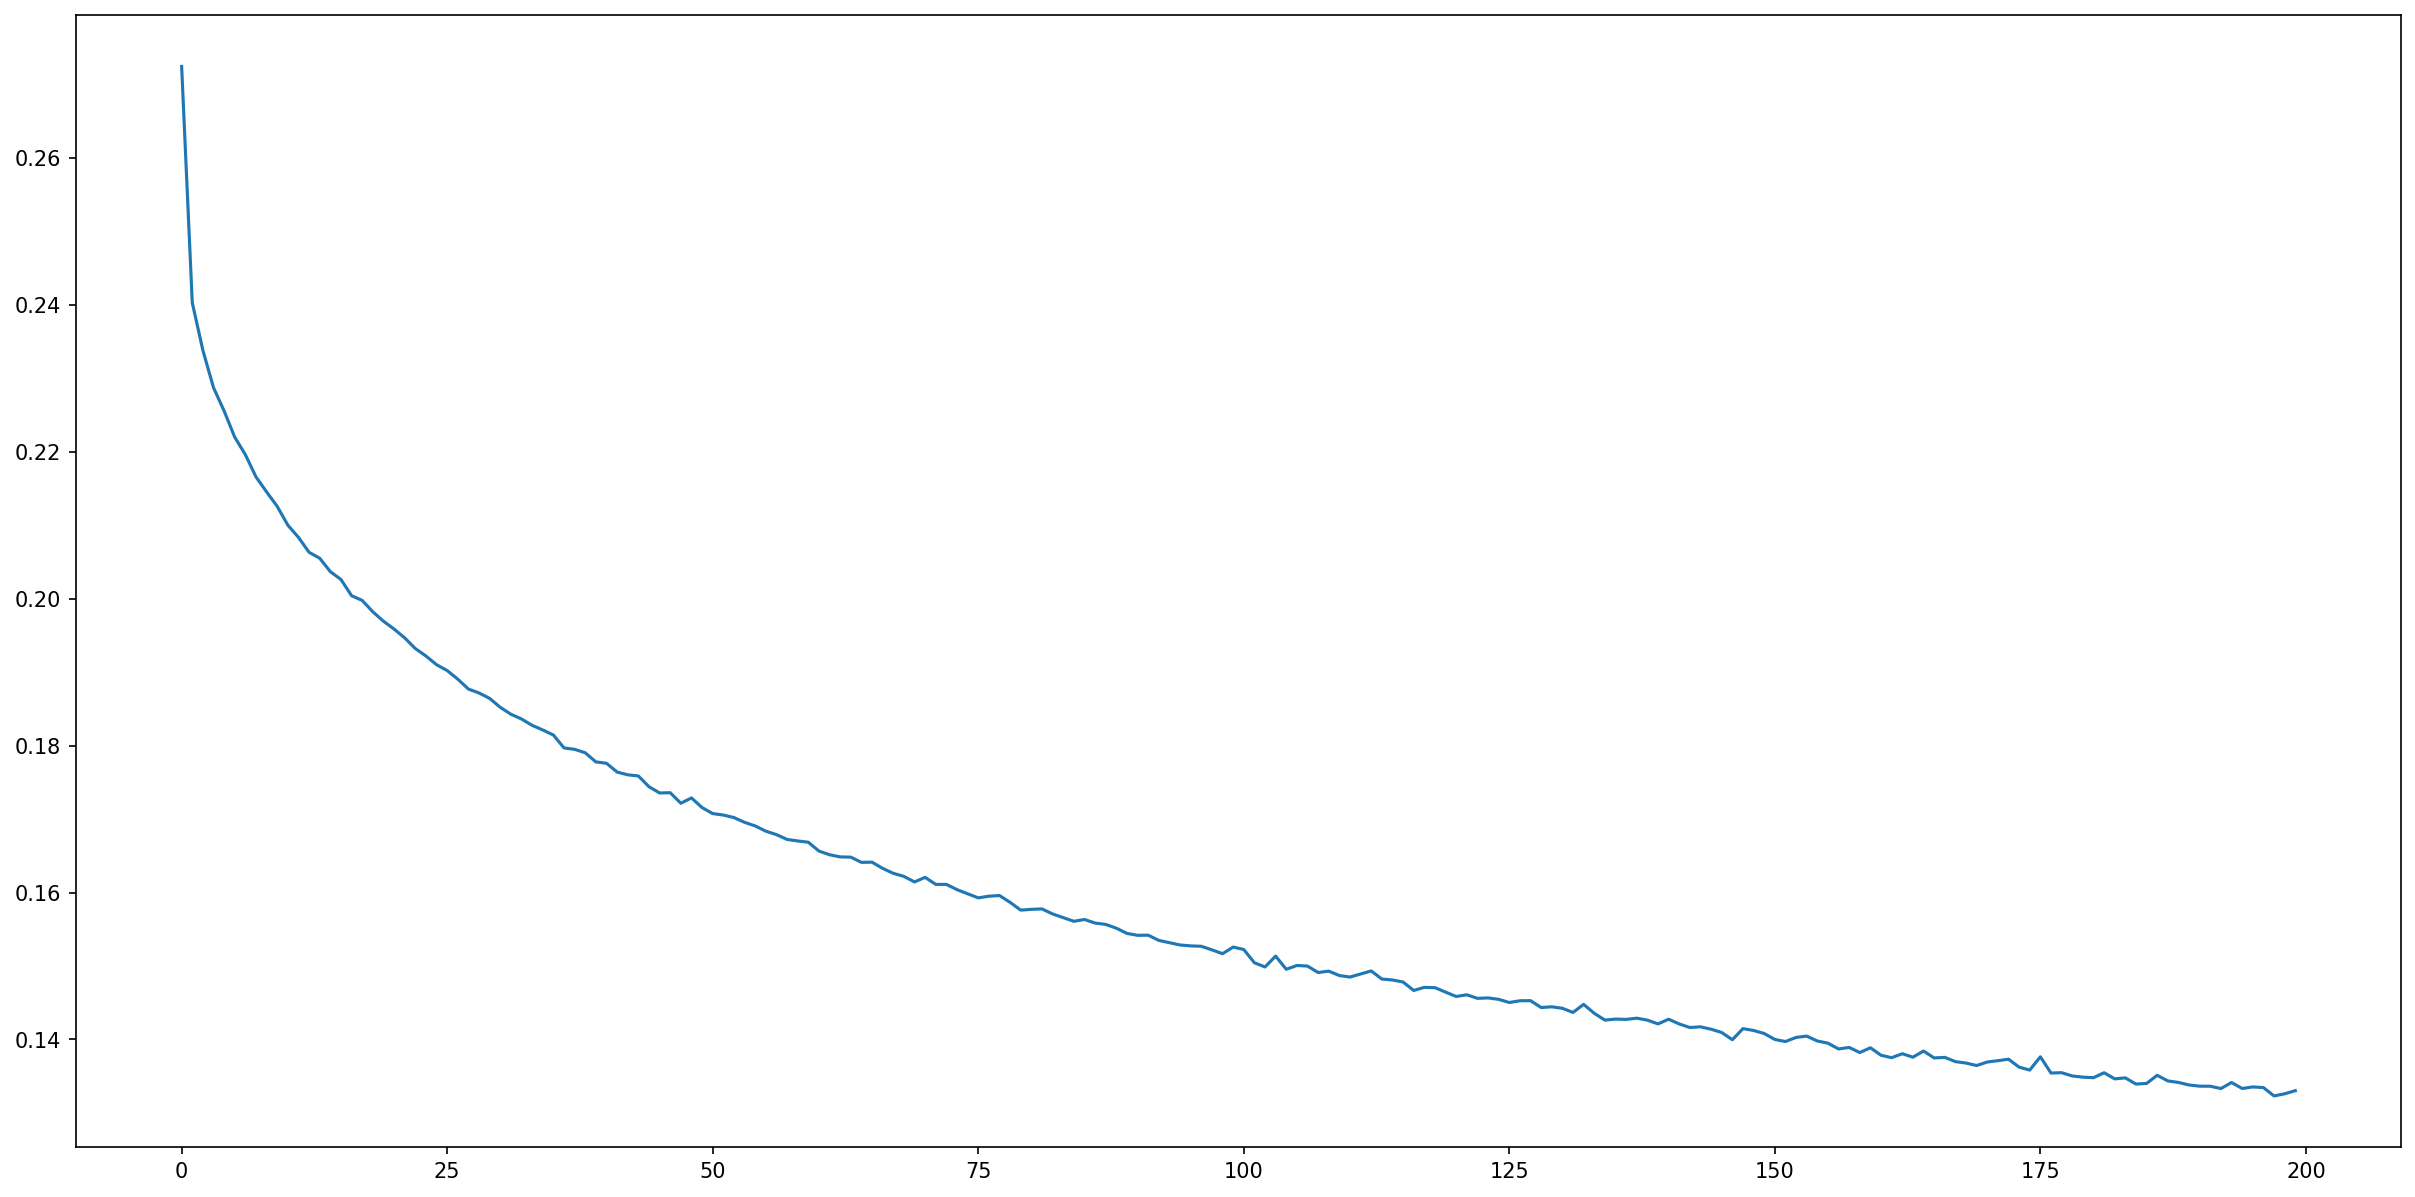

In [26]:
plt.plot(clf.loss_curve_)
plt.show()

### Parameters

hidden_layer_sizes tuple, length = n_layers - 2, default=(100,)
The ith element represents the number of neurons in the ith hidden layer.

activation {'identity', 'logistic', 'tanh', 'relu'}, default='relu'
Activation function for the hidden layer.
* 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x
* 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
* 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).
* 'relu', the rectified linear unit function, returns f(x) = max(0, x)

solver {'lbfgs', 'sgd', 'adam'}, default='adam'
The solver for weight optimization.
* 'lbfgs' is an optimizer in the family of quasi-Newton methods.
* 'sgd' refers to stochastic gradient descent.
* 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
The default solver 'adam' works pretty well on relatively large datasets (>= 1000 training samples) in terms of both training time and validation score. For small datasets, 'lbfgs' can converge faster and perform better.

alpha float, default=0.0001
L2 penalty (regularization term) parameter.

batch_size int, default='auto'
Size of minibatches for stochastic optimizers. If the solver is 'lbfgs', the classifier will not use minibatch. When set to “auto”, batch_size=min(200, n_samples)

learning_rate {'constant', 'invscaling', 'adaptive'}, default='constant'
Learning rate schedule for weight updates.
*'constant' is a constant learning rate given by 'learning_rate_init'.
*'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of *'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)
*'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.
Only used when solver='sgd'.

learning_rate_init double, default=0.001
The initial learning rate used. It controls the step-size in updating the weights. Only used when solver='sgd' or 'adam'.

power_t double, default=0.5
The exponent for inverse scaling learning rate. It is used in updating effective learning rate when the learning_rate is set to 'invscaling'. Only used when solver='sgd'.

max_iter int, default=200
Maximum number of iterations. The solver iterates until convergence (determined by 'tol') or this number of iterations. For stochastic solvers ('sgd', 'adam'), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps.

shuffle bool, default=True
Whether to shuffle samples in each iteration. Only used when solver='sgd' or 'adam'.

random_state int, RandomState instance or None, default=None
If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

tol float, default=1e-4
Tolerance for the optimization. When the loss or score is not improving by at least tol for n_iter_no_change consecutive iterations, unless learning_rate is set to 'adaptive', convergence is considered to be reached and training stops.

verbose bool, default=False
Whether to print progress messages to stdout.

warm_start bool, default=False
When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. See the Glossary.

momentum float, default=0.9
Momentum for gradient descent update. Should be between 0 and 1. Only used when solver='sgd'.

early_stopping bool, default=False
Whether to use early stopping to terminate training when validation score is not improving. If set to true, it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs. The split is stratified, except in a multilabel setting. Only effective when solver='sgd' or 'adam'

validation_fraction float, default=0.1
The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. Only used if early_stopping is True

beta_1 float, default=0.9
Exponential decay rate for estimates of first moment vector in adam, should be in [0, 1). Only used when solver='adam'

beta_2 float, default=0.999
Exponential decay rate for estimates of second moment vector in adam, should be in [0, 1). Only used when solver='adam'

epsilon float, default=1e-8
Value for numerical stability in adam. Only used when solver='adam'

n_iter_no_change int, default=10
Maximum number of epochs to not meet tol improvement. Only effective when solver='sgd' or 'adam'


### Attributes
loss_ float
The current loss computed with the loss function.

coefs_ list, length n_layers - 1
The ith element in the list represents the weight matrix corresponding to layer i.

intercepts_ list, length n_layers - 1
The ith element in the list represents the bias vector corresponding to layer i + 1.

n_iter_ int,
The number of iterations the solver has ran.

n_layers_ int
Number of layers.

n_outputs_ int
Number of outputs.

out_activation_ string
Name of the output activation function.

In [17]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32,), alpha=0.1, learning_rate='adaptive', 
                    activation='tanh', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

C:\Users\cri98\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy 0.910173399450428
F1-score [0.94896274 0.62569097]
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     27414
           1       0.71      0.56      0.63      4247

    accuracy                           0.91     31661
   macro avg       0.82      0.76      0.79     31661
weighted avg       0.90      0.91      0.91     31661



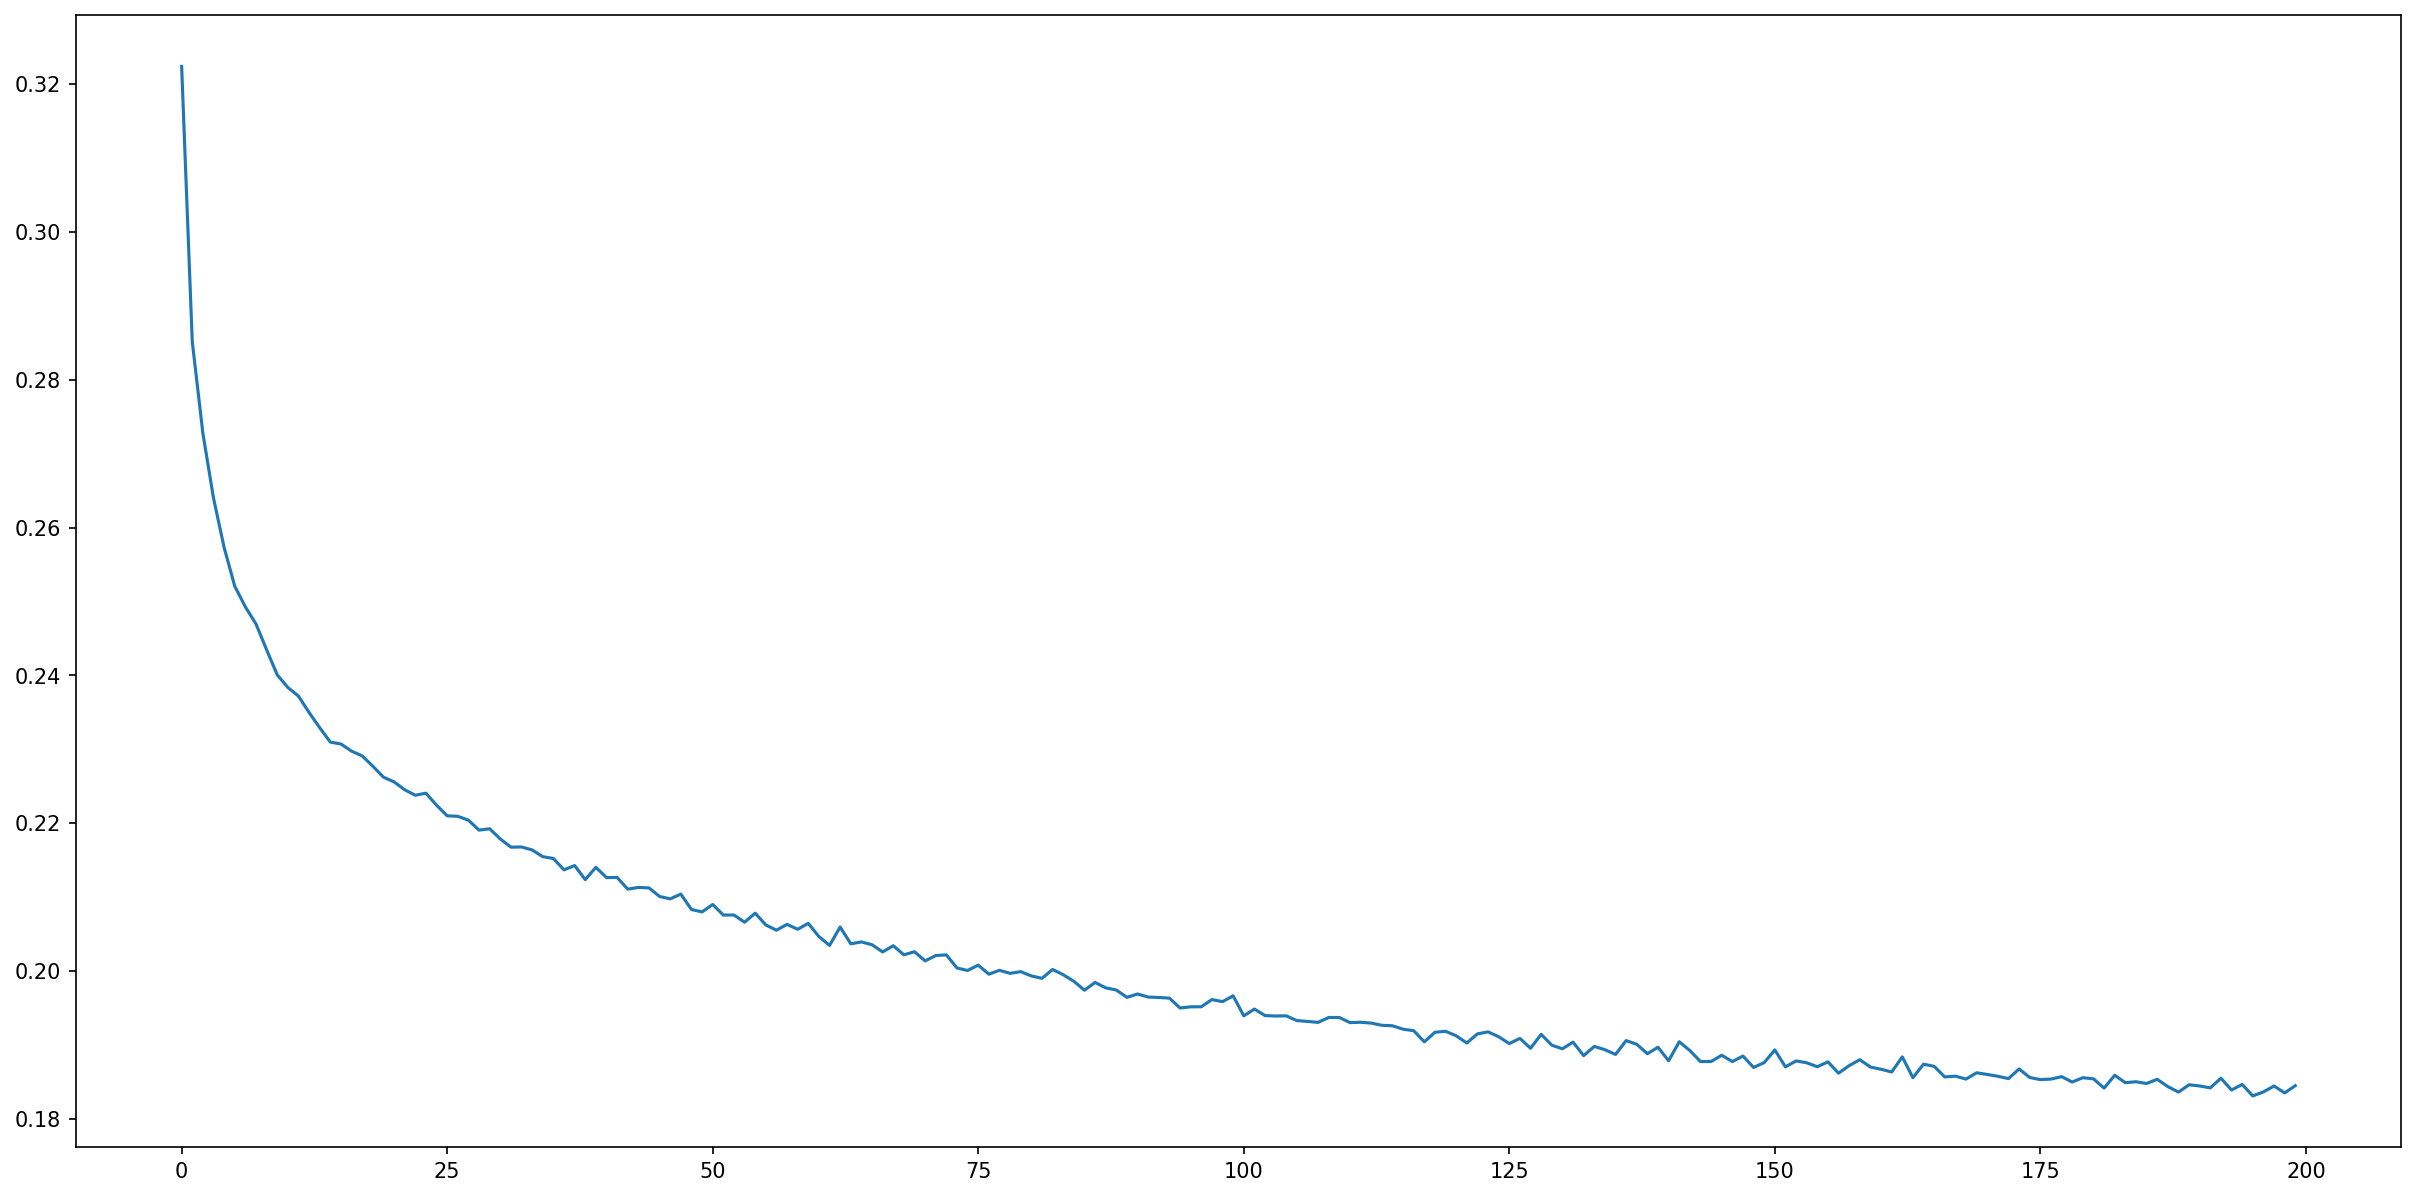

In [18]:
plt.plot(clf.loss_curve_)
plt.show()

In [ ]:
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}]

labels = ["constant learning-rate", "constant with momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum", "adam"]

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning

In [ ]:
for label, param in zip(labels, params):
    print(label)
    clf = MLPClassifier(random_state=0, max_iter=1000, **param)

    # some parameter combinations will not converge as can be seen on the
    # plots so they are ignored here
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        clf.fit(X, y)

    print("training set score and loss: %.3f, %f" % (clf.score(X, y), clf.loss_))
    plt.plot(clf.loss_curve_, label=label)
    plt.legend(loc="upper center")
    plt.show()

# Keras Deep Neural Networks

In [28]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [29]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

tf.debugging.set_log_device_placement(False)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [144]:
class_name = 'TRACK_genre_top_num'

attributes = compl + features #Diff(compl + features, ('ALBUM_favorites_', 'ALBUM_listens_', 'TRACK_number', 'TRACK_interest'))
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

#--------------Oversampling:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

#ros = RandomOverSampler(random_state=42)
#X_res, y_res = ros.fit_resample(X_train, y_train)


#sm = SMOTE(random_state=42)
#X_res, y_res = sm.fit_resample(X_train, y_train)

X_res = X_train
y_res = y_train

#-------------Undersampling
from imblearn.under_sampling import RandomUnderSampler

#rus = RandomUnderSampler(random_state=42)
#X_val, y_val = rus.fit_resample(X_val, y_val)



#scaler = MinMaxScaler()
#scaler.fit(X_res)
#X_res = scaler.transform(X_res)
#X_test = scaler.transform(X_test)



unique, counts = np.unique(y_train, return_counts=True)
print("train", dict(zip(unique, counts)))

unique, counts = np.unique(y_res, return_counts=True)
print("bilanciato", dict(zip(unique, counts)))

unique, counts = np.unique(y_val, return_counts=True)
print("validation", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("test", dict(zip(unique, counts)))

y_res = tf.keras.utils.to_categorical(y_res, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

train {0: 1159, 1: 700, 2: 1259, 3: 7938, 4: 5148, 5: 5929, 6: 1543, 7: 1983, 8: 1175, 9: 759}
bilanciato {0: 1159, 1: 700, 2: 1259, 3: 7938, 4: 5148, 5: 5929, 6: 1543, 7: 1983, 8: 1175, 9: 759}
validation {0: 266, 1: 148, 2: 369, 3: 1970, 4: 1333, 5: 1452, 6: 398, 7: 492, 8: 274, 9: 197}
test {0: 611, 1: 364, 2: 697, 3: 4247, 4: 2778, 5: 3163, 6: 832, 7: 1061, 8: 621, 9: 409}


In [166]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
#model.add(Dense(1, activation=tf.nn.sigmoid))
model.add(Dense(10, activation=tf.nn.softmax))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #<-- binario
model.compile(loss='categorical_crossentropy', 
              metrics=['accuracy']
             optimizer='adam') #<-- multilabel/multiclass



class_weight = {0: 1,
                1: 100}

es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_loss', save_best_only=True)

history1 = model.fit(X_res, y_res, epochs=1000, 
                      #batch_size= 128,
                      #class_weight=class_weight,
                      validation_data=(X_val, y_val), callbacks=[es,mc]
                     ).history

Epoch 1/1000
863/863 [==============================] - 1s 2ms/step - loss: 4465925966604516982784.0000 - accuracy: 0.2854 - val_loss: 2.0060 - val_accuracy: 0.2855
Epoch 2/1000
863/863 [==============================] - 1s 1ms/step - loss: 1.9941 - accuracy: 0.2853 - val_loss: 1.9650 - val_accuracy: 0.2855
Epoch 3/1000
863/863 [==============================] - 1s 1ms/step - loss: 1.9648 - accuracy: 0.2842 - val_loss: 1.9570 - val_accuracy: 0.2855
Epoch 4/1000
863/863 [==============================] - 1s 1ms/step - loss: 1.9478 - accuracy: 0.2868 - val_loss: 1.9546 - val_accuracy: 0.2855
Epoch 5/1000
863/863 [==============================] - 1s 2ms/step - loss: 1.9604 - accuracy: 0.2853 - val_loss: 1.9535 - val_accuracy: 0.2855
Epoch 6/1000
863/863 [==============================] - 1s 2ms/step - loss: 1.9487 - accuracy: 0.2907 - val_loss: 1.9529 - val_accuracy: 0.2855
Epoch 7/1000
863/863 [==============================] - 1s 1ms/step - loss: 1.9496 - accuracy: 0.2895 - val_loss: 1

In [151]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss, test_acc))

462/462 [==============================] - 0s 981us/step - loss: 1.9528 - accuracy: 0.2873
Loss 1.952803, Accuracy 0.287289


In [152]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [154]:
y_pred = model.predict(X_test)

y_pred_bool = np.argmax(y_pred, axis=1) #si deve usare argmax o predict_classes
y_test_bool = np.argmax(y_test, axis=1)

print(classification_report(y_test_bool, y_pred_bool))

#print('Accuracy %s' % accuracy_score(y_test, y_pred))
#print('F1-score %s' % f1_score(y_test, y_pred, average=None))
#print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       611
           1       0.00      0.00      0.00       364
           2       0.00      0.00      0.00       697
           3       0.29      1.00      0.45      4247
           4       0.00      0.00      0.00      2778
           5       0.00      0.00      0.00      3163
           6       0.00      0.00      0.00       832
           7       0.00      0.00      0.00      1061
           8       0.00      0.00      0.00       621
           9       0.00      0.00      0.00       409

    accuracy                           0.29     14783
   macro avg       0.03      0.10      0.04     14783
weighted avg       0.08      0.29      0.13     14783



/home/cri98li/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cri98li/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cri98li/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [155]:
for array in y_pred:
    print(array, np.argmax(array))


[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0

[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0

[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0

[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0

 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.0454394

[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0

[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0

[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0

[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0

[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0

[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0

 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.0454394

 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.0454394

 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.0454394

[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0

[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0

[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0

[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0

 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.0454394

[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0

[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0

 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.04543947 0.28578877 0.18873611 0.21358506
 0.05649212 0.07145818 0.04283821 0.02779685] 3
[0.04241603 0.02544916 0.0454394

In [156]:
#PROBLEMA QUI (predice soltanto 3 (rock) che è la classe di maggioranza)

y_pred = model1.predict_classes(X_test)

unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

/home/cri98li/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


{3: 14783}

In [161]:
unique, counts = np.unique(np.argmax(y_test, axis=1), return_counts=True)
dict(zip(unique, counts))

{0: 611,
 1: 364,
 2: 697,
 3: 4247,
 4: 2778,
 5: 3163,
 6: 832,
 7: 1061,
 8: 621,
 9: 409}

In [122]:
y_pred = model1.predict(X_test)
y_pred

array([[0.04161637, 0.02447254, 0.04831347, ..., 0.07187239, 0.04169554,
        0.02754219],
       [0.04161637, 0.02447254, 0.04831347, ..., 0.07187239, 0.04169554,
        0.02754219],
       [0.04161637, 0.02447254, 0.04831347, ..., 0.07187239, 0.04169554,
        0.02754219],
       ...,
       [0.04161637, 0.02447254, 0.04831347, ..., 0.07187239, 0.04169554,
        0.02754219],
       [0.04161637, 0.02447254, 0.04831347, ..., 0.07187239, 0.04169554,
        0.02754219],
       [0.04161637, 0.02447254, 0.04831347, ..., 0.07187239, 0.04169554,
        0.02754219]], dtype=float32)

## tuning parametri

In [182]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

def build_model(n_layers=2, h_dim=64, activation='relu', optimizer='adam'):
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    
    model.add(Dense(h_dim, activation=activation, input_shape=(n_feature,)))
    for i in range(n_layers-1):
        model.add(Dense(h_dim, activation=activation))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [177]:
class_name = 'target'

attributes = compl + features #Diff(compl + features, ('ALBUM_favorites_', 'ALBUM_listens_', 'TRACK_number', 'TRACK_interest'))
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

#--------------Oversampling:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

#ros = RandomOverSampler(random_state=42)
#X_res, y_res = ros.fit_resample(X_train, y_train)


#sm = SMOTE(random_state=42)
#X_res, y_res = sm.fit_resample(X_train, y_train)

X_res = X_train
y_res = y_train

#-------------Undersampling
from imblearn.under_sampling import RandomUnderSampler

#rus = RandomUnderSampler(random_state=42)
#X_val, y_val = rus.fit_resample(X_val, y_val)



#scaler = MinMaxScaler()
#scaler.fit(X_res)
#X_res = scaler.transform(X_res)
#X_test = scaler.transform(X_test)





In [178]:
# parametri rendomized search

n_layers = [1, 2, 3, 4]
h_dim = [32, 64, 128]
activation = ['relu', 'tanh']
optimizer = ['adagrad', 'adam']
params = dict(optimizer=optimizer, n_layers=n_layers, h_dim=h_dim, activation=activation)

In [183]:
model = KerasClassifier(build_fn=build_model)

rnd = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=5, cv=3, n_jobs=22)
rnd_result = rnd.fit(X_train, y_train, epochs=100, batch_size=10, verbose=10)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100


KeyboardInterrupt: 

In [170]:
print("Best: %f using %s" % (-rnd_result.best_score_, rnd_result.best_params_))
means = rnd_result.cv_results_['mean_test_score']
stds = rnd_result.cv_results_['std_test_score']
params = rnd_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))

NameError: name 'rnd_result' is not defined

In [ ]:
clf = rnd_result.best_estimator_.model

loss, acc = clf.evaluate(X_test, y_test)
print('Loss %f, Accuracy %f' % (loss, acc))

In [134]:
24*24

576

# Random Forest

In [172]:
class_name = 'target'

attributes = compl + features #Diff(compl + features, ('ALBUM_favorites_', 'ALBUM_listens_', 'TRACK_number', 'TRACK_interest'))
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)


In [173]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, 
                             criterion='gini', 
                             max_depth=None, 
                             min_samples_split=10, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             random_state=0,
                            class_weight = 'balanced')


clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8785767435567882
F1-score [0.9182642  0.76397107]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     10536
           1       0.87      0.68      0.76      4247

    accuracy                           0.88     14783
   macro avg       0.87      0.82      0.84     14783
weighted avg       0.88      0.88      0.87     14783



In [119]:
from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [10],
              'min_samples_leaf': [1],
              'n_estimators' : range(1000, 1300 +1, 100)
             }

clf = RandomForestClassifier(criterion='gini', 
                             max_depth=None, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             random_state=0,
                             class_weight='balanced'
                            )


grid_search = GridSearchCV(clf, param_grid, n_jobs=22, verbose=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=22)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   4 out of  20 | elapsed:  3.4min remaining: 13.8min
[Parallel(n_jobs=22)]: Done   7 out of  20 | elapsed:  3.5min remaining:  6.5min
[Parallel(n_jobs=22)]: Done  10 out of  20 | elapsed:  3.8min remaining:  3.8min
[Parallel(n_jobs=22)]: Done  13 out of  20 | elapsed:  4.1min remaining:  2.2min
[Parallel(n_jobs=22)]: Done  16 out of  20 | elapsed:  4.1min remaining:  1.0min
[Parallel(n_jobs=22)]: Done  20 out of  20 | elapsed:  4.4min finished


GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=0),
             n_jobs=22,
             param_grid={'min_samples_leaf': [1], 'min_samples_split': [10],
                         'n_estimators': range(1000, 1301, 100)},
             scoring='accuracy', verbose=10)

In [118]:
report(grid_search.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.876 (std: 0.006)
Parameters: {'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}

Model with rank: 2
Mean validation score: 0.875 (std: 0.006)
Parameters: {'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 900}

Model with rank: 3
Mean validation score: 0.875 (std: 0.005)
Parameters: {'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 700}

Model with rank: 4
Mean validation score: 0.875 (std: 0.005)
Parameters: {'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 800}

Model with rank: 5
Mean validation score: 0.870 (std: 0.003)
Parameters: {'min_samples_leaf': 1, 'min_samples_split': 50, 'n_estimators': 1000}

Model with rank: 6
Mean validation score: 0.870 (std: 0.003)
Parameters: {'min_samples_leaf': 1, 'min_samples_split': 50, 'n_estimators': 800}

Model with rank: 7
Mean validation score: 0.870 (std: 0.003)
Parameters: {'min_samples_leaf': 1, 'min_samples_split': 50, 'n_estimator

In [120]:
report(grid_search.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.876 (std: 0.006)
Parameters: {'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1100}

Model with rank: 2
Mean validation score: 0.876 (std: 0.006)
Parameters: {'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}

Model with rank: 3
Mean validation score: 0.876 (std: 0.006)
Parameters: {'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1200}

Model with rank: 4
Mean validation score: 0.875 (std: 0.006)
Parameters: {'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1300}

